# **AIR QUALITY PREDICTION**

**GOALS**
- Prepare Time Series Data
- Predicting NO2(GT) Readings with Linear Regression.

**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pytz
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## PREPARE DATA

### IMPORT DATA

In [2]:


def wrangle(filepath):
    """Importing csv file, creating a new column 'Timestamp', concatenating 'Time' and 'Date' columns.
    Extract only two columns, 'Timestamp' and 'NO2(GT)'.

    Args:
        filepath (str): Path to the csv file.
    Returns:
        df (pd.DataFrame): DataFrame with two columns: 'Timestamp' and 'NO2(GT)'.
    """
    # Read csv file
    data = pd.read_csv(filepath)
    
    # Create a new column 'Timestamp' concatenating Date and Time columns
    data["Timestamp"] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    
    # Localize 'Timestamp' to CET timezone
    data["Timestamp"] = data["Timestamp"].dt.tz_localize('CET', ambiguous='NaT', nonexistent='NaT')
    
    # Extract new DataFrame with two columns 'Timestamp' and 'NO2(GT)'
    df = data[["Timestamp", "NO2(GT)"]].copy()
    
    # Set 'Timestamp' as the index
    df.set_index("Timestamp", inplace=True)
    
    # Remove Outliers
    df = df[(df["NO2(GT)"] != -200) & (df["NO2(GT)"] <= 300)]
    
    # Create Lag Feature
    df["NO2(GT).P1"] = df["NO2(GT)"].shift(1)
    
    # Drop null values
    df.dropna(inplace=True)
    
    return df



**Wrangle Function**
- The wrangle function localizes the Timezone to Central European Time(CET) since the dataset was originally collected in Italy, Milan.
- We also drop the null observations in our dataset.

In [3]:
# Use the wrangle function
filepath = "AirQualityUCI.csv"
df = wrangle(filepath)
print("df shape:", df.shape)
df.head()

df shape: (7705, 2)


,NO2(GT),NO2(GT).P1
Timestamp,,
2004-03-10 19:00:00+01:00,92.0,113.0
2004-03-10 20:00:00+01:00,114.0,92.0
2004-03-10 21:00:00+01:00,122.0,114.0
2004-03-10 22:00:00+01:00,116.0,122.0
2004-03-10 23:00:00+01:00,96.0,116.0


**Information of the dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7705 entries, 2004-03-10 19:00:00+01:00 to 2005-04-04 14:00:00+02:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NO2(GT)     7705 non-null   float64
 1   NO2(GT).P1  7705 non-null   float64
dtypes: float64(2)
memory usage: 180.6 KB


## **EXPLORE**

**Boxplot of NO2[GT]**

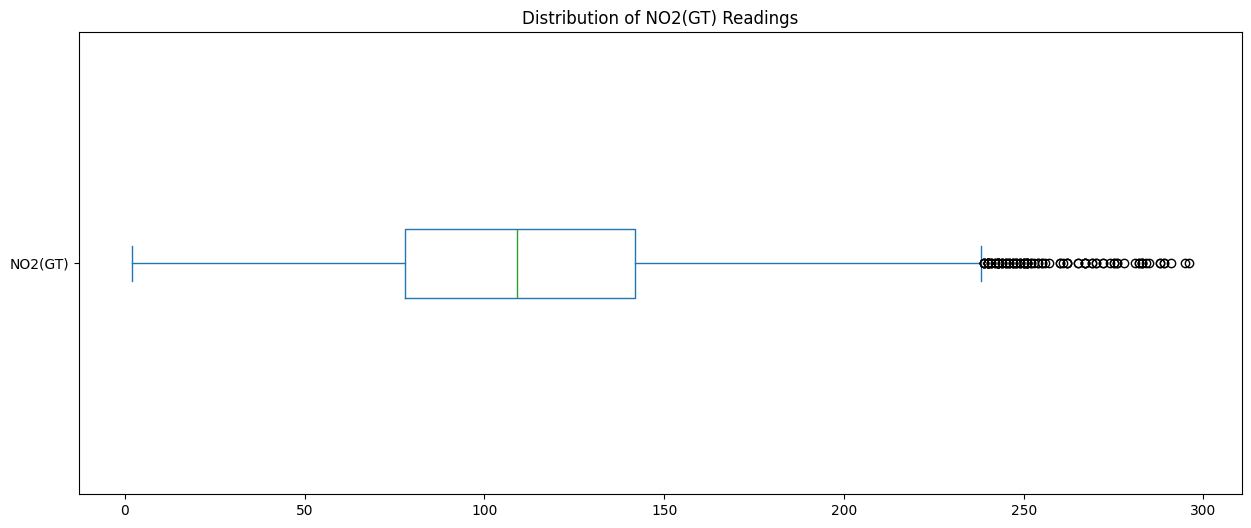

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
df["NO2(GT)"].plot(kind="box", vert=False, title="Distribution of NO2(GT) Readings", ax=ax);

**Outliers**

NO2(GT) Readings above 300 are considered highly unhealthy, hence when removing the outliers in our distribution there is a need to use a cuttoff of 300.

**Time Series Plot**

In [6]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

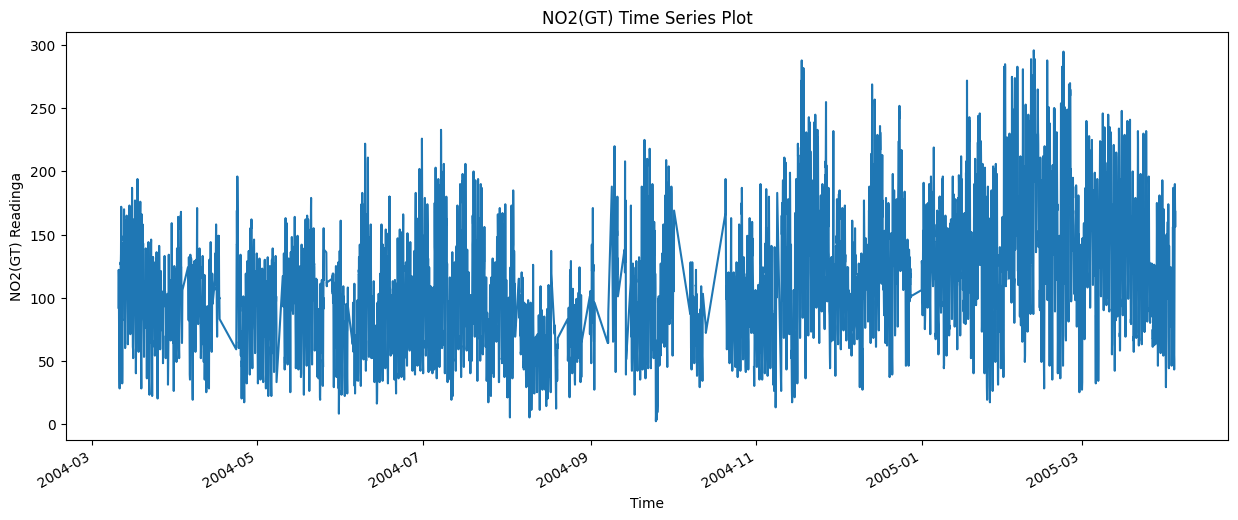

In [7]:
# Make Timestamp timezone-naive before plotting
df.index = df.index.tz_localize(None)

fig, ax = plt.subplots(figsize=(15, 6))
df["NO2(GT)"].plot(xlabel="Time", ylabel="NO2(GT) Readinga", title="NO2(GT) Time Series Plot", ax=ax);

**Resample Time Series**

Resampling the data to hourly cycles, enable us to capture fluctuations in our data, giving us insights.

In [9]:
df["NO2(GT)"].resample("h").mean().ffill().to_frame().head()

,NO2(GT)
Timestamp,
2004-03-10 19:00:00,92.0
2004-03-10 20:00:00,114.0
2004-03-10 21:00:00,122.0
2004-03-10 22:00:00,116.0
2004-03-10 23:00:00,96.0


**Rollling Average**

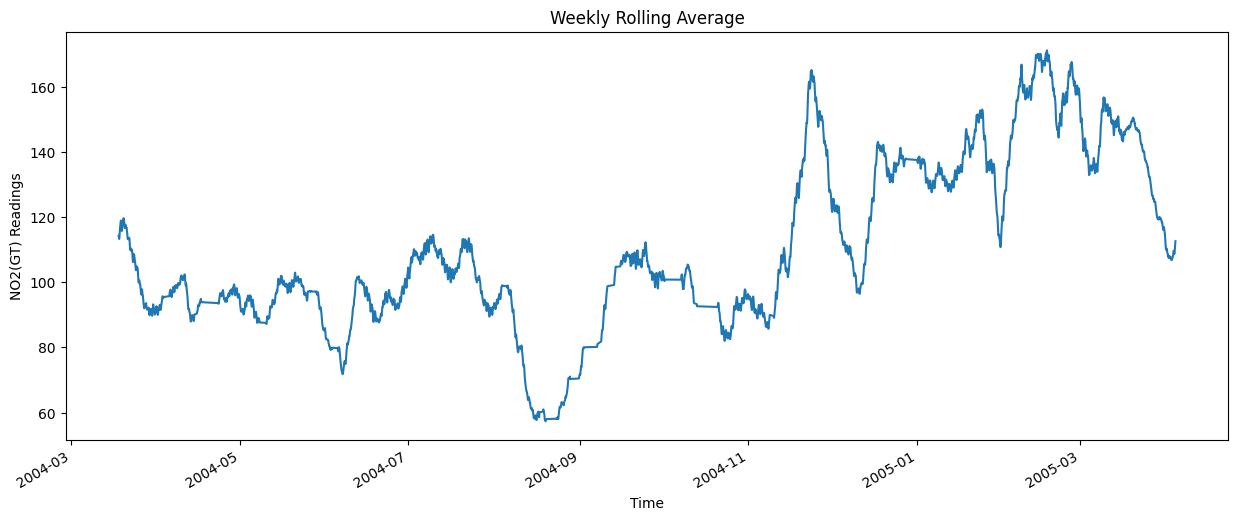

In [10]:
fig, ax, plt.subplots(figsize=(15,6))
df["NO2(GT)"].rolling(168).mean(1).plot(xlabel="Time", ylabel="NO2(GT) Readings", title="Weekly Rolling Average");

## **Linear Regression Model**

**Create Lag Feature**

 We will add to our wrangle function to create a column called "NO2(GT).P1" that contains the mean"NO2(GT)" reading from the previous hour. Since this new feature will create NaN values in your DataFrame, we will drop null rows from df

In [11]:
df.head()

,NO2(GT),NO2(GT).P1
Timestamp,,
2004-03-10 19:00:00,92.0,113.0
2004-03-10 20:00:00,114.0,92.0
2004-03-10 21:00:00,122.0,114.0
2004-03-10 22:00:00,116.0,122.0
2004-03-10 23:00:00,96.0,116.0


Lag features will allow our model to consider past values as predictors for future outcomes.

**Correlation**

In [12]:
corr = df.corr()
corr

,NO2(GT),NO2(GT).P1
NO2(GT),1.000000,0.896899
NO2(GT).P1,0.896899,1.000000


**Autocorrelation Plot**

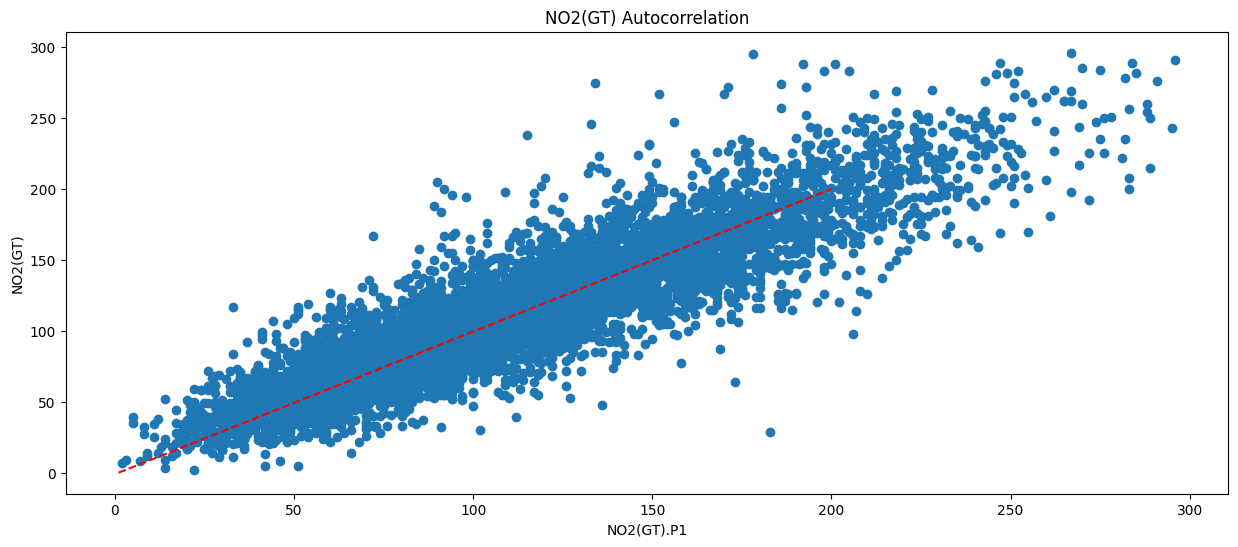

In [13]:
fig, ax, plt.subplots(figsize=(15, 6))
plt.scatter(x=df["NO2(GT).P1"], y=df["NO2(GT)"])
plt.plot([1, 200], [0, 200], linestyle="--", color="red")
plt.xlabel("NO2(GT).P1")
plt.ylabel("NO2(GT)")
plt.title("NO2(GT) Autocorrelation");

### **Split Data**

**Vertical Split**

In [14]:

target = "NO2(GT)"
y = df[target]
X = df.drop(columns=target)

**Train Test Split**

Divide data into training and test sets

In [15]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6164, 1)
y_train shape: (6164,)
X_test shape: (1541, 1)
y_test shape: (1541,)


## **BUILD MODEL**

### Baseline

In [16]:
# Calculate mean for y_train
y_mean = y_train.mean()
print("Training Mean:", y_mean)

# Baseline
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Training MAE:", round(mae_baseline, 2))

Training Mean: 105.13724853990915
Training MAE: 34.52


### Iterate

In [17]:
model = make_pipeline(
    LinearRegression())
model.fit(X_train, y_train)
model

Pipeline(steps=[('linearregression', LinearRegression())])

## **EVALUATE**

In [20]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 14.84
Test MAE: 19.65


### Communicate Results

In [22]:
intercept = model.intercept_
coefficient = model.coef_
print(f"NO2(GT) = {intercept} + c{coefficient} * NO2(GT).P1")

NO2(GT) = 11.43444622249659 + c[0.89119317] * NO2(GT).P1


Prediciton Dataframe

In [24]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }
)
df_pred_test.tail()

,y_test,y_pred
Timestamp,,
2005-04-04 10:00:00,190.0,178.087568
2005-04-04 11:00:00,179.0,180.761148
2005-04-04 12:00:00,175.0,170.958023
2005-04-04 13:00:00,156.0,167.393250
2005-04-04 14:00:00,168.0,150.460580


**Plot Time Series Prediction**

In [25]:
fig = px.line(df_pred_test, labels={"value": "NO2(GT)"})
fig.show()